# California Housing Prices

In [125]:
import os 
import tarfile
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats

import optuna
from typing import List
from tqdm import tqdm
import warnings
# Adjust display settings for better readability
pd.set_option("display.max_rows", 100)  # Adjust maximum rows to show
pd.set_option("display.max_columns", 10)  # Adjust maximum columns to show
pd.set_option("display.width", 1000)  # Set display width to accommodate all columns
pd.set_option("display.colheader_justify", "left")  # Left-justify column headers
pd.set_option("display.float_format", "{:.3f}".format)  # Floating-point precision to 3 decimals
warnings.filterwarnings('ignore')
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("data")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
colors = [
    "#03256C",
    "#2541B2",
    "#1768AC",
    "#E5D549",
]
sns.set_palette(sns.color_palette(colors))


In [4]:
# def fetch_data(url=HOUSING_URL, path=HOUSING_PATH):
#     if not os.path.isdir(path):
#         os.makedirs(path)
#     tgz_path = os.path.join(path,"housing.tgz")
#     urllib.request.urlretrieve(url, tgz_path)
#     data = tarfile.open(tgz_path)
#     data.extractall(path=path)
#     data.close()

def load_data(path=HOUSING_PATH):
    csv_path = os.path.join(path,'housing.csv')
    return pd.read_csv(csv_path)

In [5]:
try:
    if not os.path.isdir(HOUSING_PATH):
        os.makedirs(HOUSING_PATH)
        fetch_data()
except:
  print('An exception occurred')

df= load_data(path=HOUSING_PATH)

In [6]:
df.head(), df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


(   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
 0    -122.23     37.88                41.0        880.0           129.0   
 1    -122.22     37.86                21.0       7099.0          1106.0   
 2    -122.24     37.85                52.0       1467.0           190.0   
 3    -122.25     37.85                52.0       1274.0           235.0   
 4    -122.25     37.85                52.0       1627.0           280.0   
 
    population  households  median_income  median_house_value ocean_proximity  
 0       322.0       126.0         8.3252            452600.0        NEAR BAY  
 1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
 2       496.0       177.0         7.2574            352100.0        NEAR BAY  
 3       558.0       219.0         5.6431            341300.0        NEAR BAY  
 4       565.0       259.0         3.8462            342200.0        NEAR BAY  ,
 None,
           longitude      latitude  housing_median_age

In [7]:
target_col = 'median_house_value'
num_cols = df.select_dtypes(include=[np.number]).columns.values
cat_cols = df.select_dtypes(exclude=[np.number]).columns.values
num_cols,cat_cols

(array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'median_house_value'], dtype=object),
 array(['ocean_proximity'], dtype=object))

- Conclusion: 
  - Numerical Feature: `['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income',
  'median_house_value']`

  - Categorical Feature: ` 'ocean_proximity'`
  - Target Feature: `'median_house_value'`

# Sanity Check

In [8]:
df.isna().sum()*100 / df.shape[0]

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.002907
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

In [9]:
df.isna()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
20635,False,False,False,False,False,False,False,False,False,False
20636,False,False,False,False,False,False,False,False,False,False
20637,False,False,False,False,False,False,False,False,False,False
20638,False,False,False,False,False,False,False,False,False,False


<Axes: >

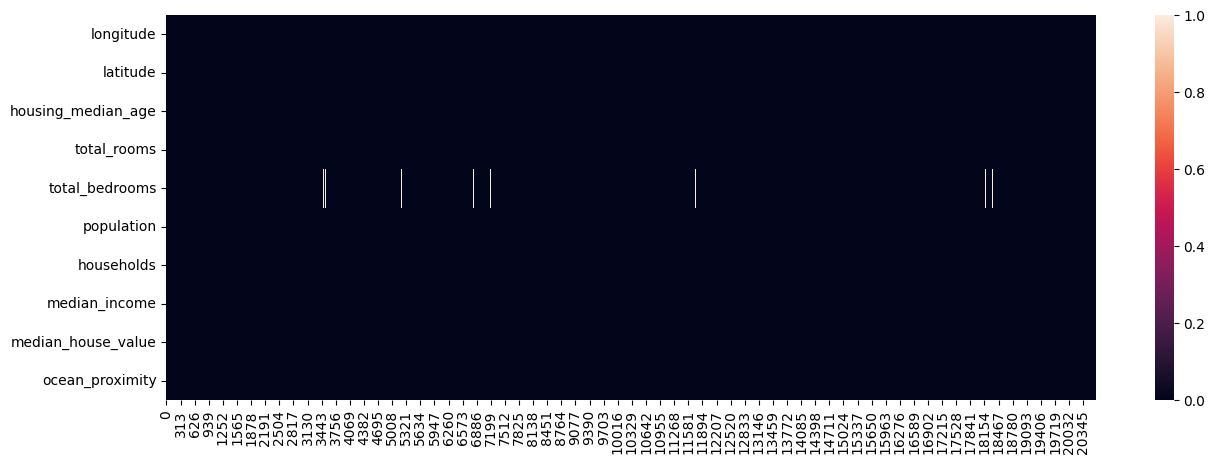

In [10]:
_, ax = plt.subplots(figsize=(15,5))
sns.heatmap(
    df.isna().transpose(),
    ax = ax
)

In the above code snippet, we're generating a heatmap to visualize the distribution of missing values in our DataFrame, `df`. The heatmap is structured such that each column of `df` is represented on the x-axis, and each row corresponds to a boolean value indicating the presence (or absence) of missing data.

The color intensity in the heatmap provides a quick, visual representation of our data's completeness. Dark cells indicate that the corresponding data point in `df` is not missing, while lighter cells signify missing or NaN values. This visualization technique allows us to quickly identify patterns or clusters of missing data, which can be incredibly useful in the data cleaning and preprocessing stages of our analysis.

## Duplication

In [11]:
df.duplicated().sum()

0

# Discussion:

- Observations:
    - We've identified that the `total_bedrooms` column has approximately 1% of its data missing.
    - Upon checking for duplicate entries, we found that our dataset does not contain any duplications.

# EDA

In [12]:
def displot(df: pd.DataFrame, target_col: str, bins: int):
    _, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

    sns.histplot(
        df[target_col], 
        bins=bins,
        ax=ax1)
    ax1.set(
        title=f'Histogram of {target_col} column',
        ylabel='Frequency',
        xlabel=target_col
    )

    stats.probplot(df[target_col], plot=ax2)
    ax2.set(
        title=f'Q-Q plot of {target_col} column'
    )
    plt.show()

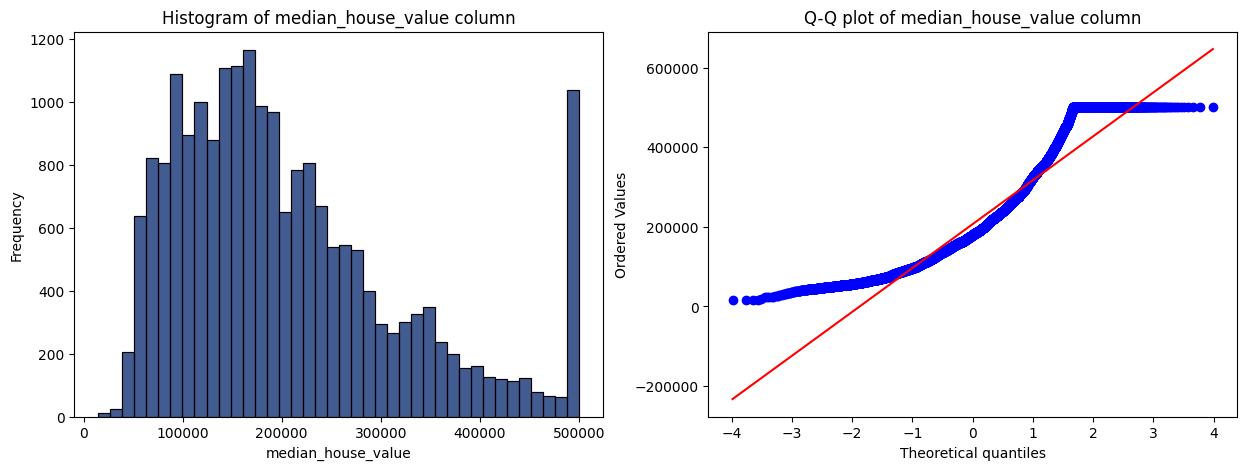

In [13]:
bins=40 
displot(df, target_col, bins)

In [14]:
max_value = df[target_col].max()
df.query(f'{target_col} == {max_value}').shape[0]

965

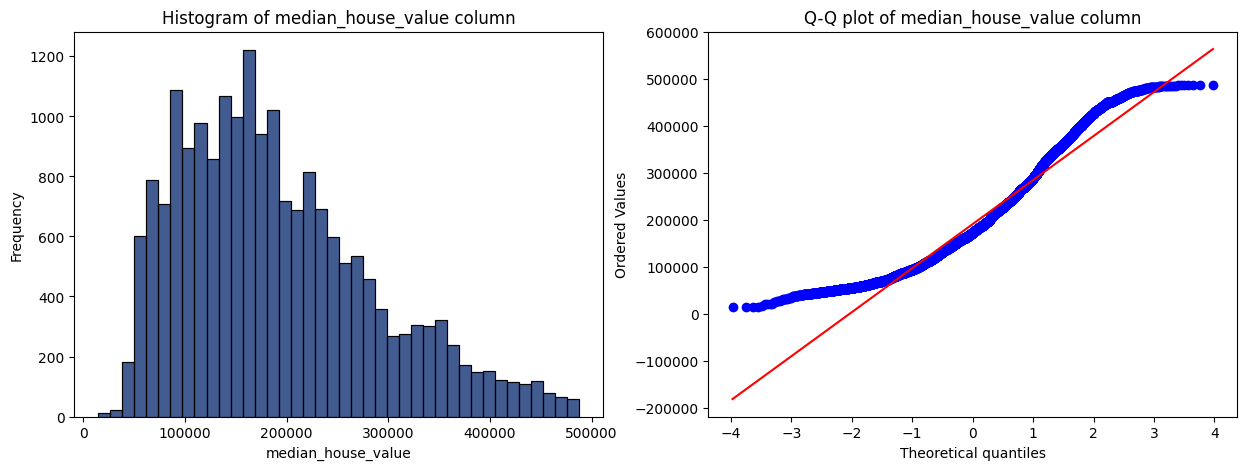

In [15]:
displot(df.query(f'median_house_value < {max_value - round(max_value/bins)}'), target_col, bins)

## Feature

### Categorical Features

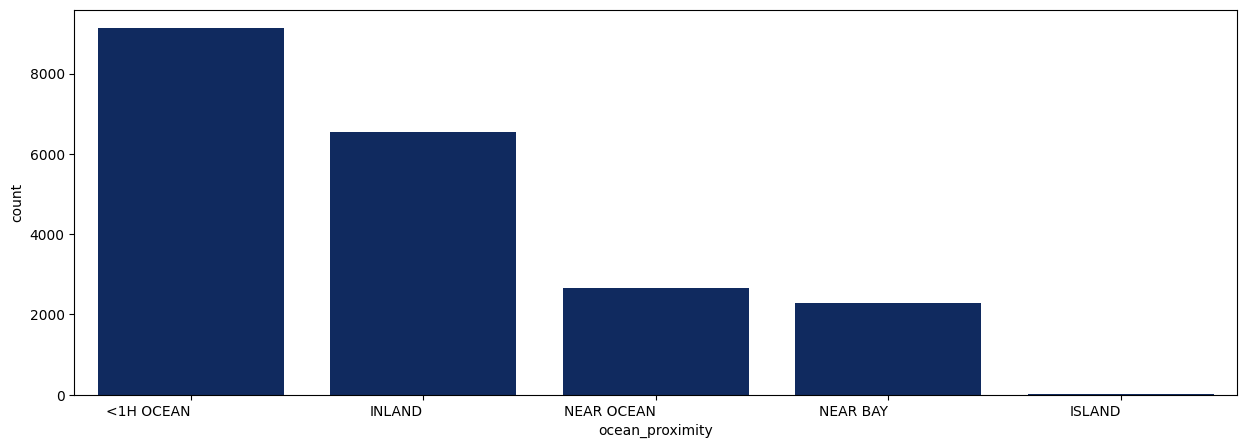

In [16]:
_, ax = plt.subplots(figsize=(15,5))
order = df[cat_cols[0]].value_counts().index
sns.countplot(
    data=df, 
    x=cat_cols[0], 
    ax=ax, 
    order = order)

ax.set_xticks(
    ax.get_xticks(), 
    ax.get_xticklabels(), 
    rotation=0, 
    ha='right')
plt.show()

In [17]:
df.loc[df[cat_cols[0]] == 'ISLAND']

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
8314,-118.32,33.35,27.0,1675.0,521.0,744.0,331.0,2.1579,450000.0,ISLAND
8315,-118.33,33.34,52.0,2359.0,591.0,1100.0,431.0,2.8333,414700.0,ISLAND
8316,-118.32,33.33,52.0,2127.0,512.0,733.0,288.0,3.3906,300000.0,ISLAND
8317,-118.32,33.34,52.0,996.0,264.0,341.0,160.0,2.7361,450000.0,ISLAND
8318,-118.48,33.43,29.0,716.0,214.0,422.0,173.0,2.6042,287500.0,ISLAND


In [18]:
summ_df = (
    df.groupby(cat_cols[0])['median_house_value']
    .agg(['mean', 'median', 'std'])
    .sort_values('mean')
)

summ_df.round(2)

,mean,median,std
ocean_proximity,,,
INLAND,124805.39,108500.0,70007.91
<1H OCEAN,240084.29,214850.0,106124.29
NEAR OCEAN,249433.98,229450.0,122477.15
NEAR BAY,259212.31,233800.0,122818.54
ISLAND,380440.00,414700.0,80559.56


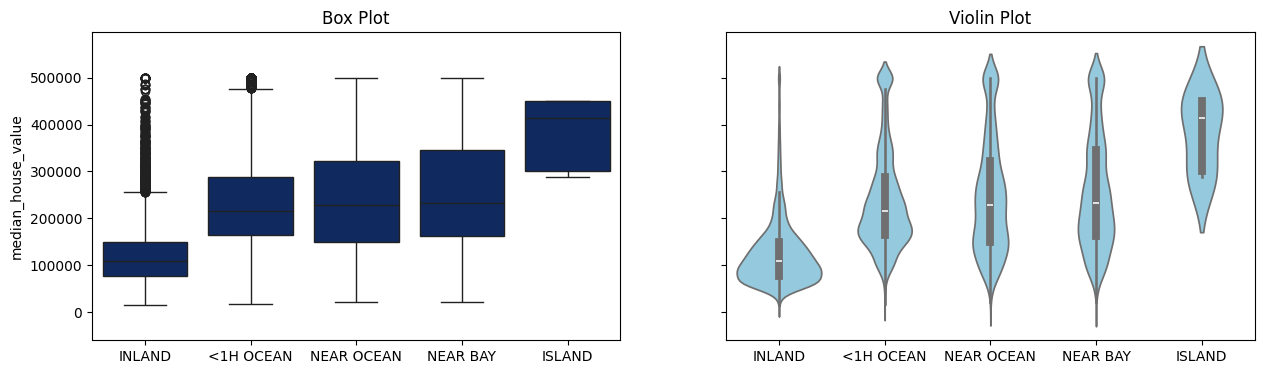

In [19]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4), sharey=True)

sns.boxplot(data=df, 
            x=cat_cols[0], 
            y='median_house_value', 
            order=summ_df.index.to_list(), 
            ax=ax1)
ax1.set(xlabel='', title='Box Plot')

sns.violinplot(data=df, 
               x=cat_cols[0], 
               y='median_house_value', 
               order=summ_df.index.to_list(), 
               ax=ax2,
               color='skyblue')
ax2.set(xlabel='', title='Violin Plot')

plt.show()

### Numerical Features

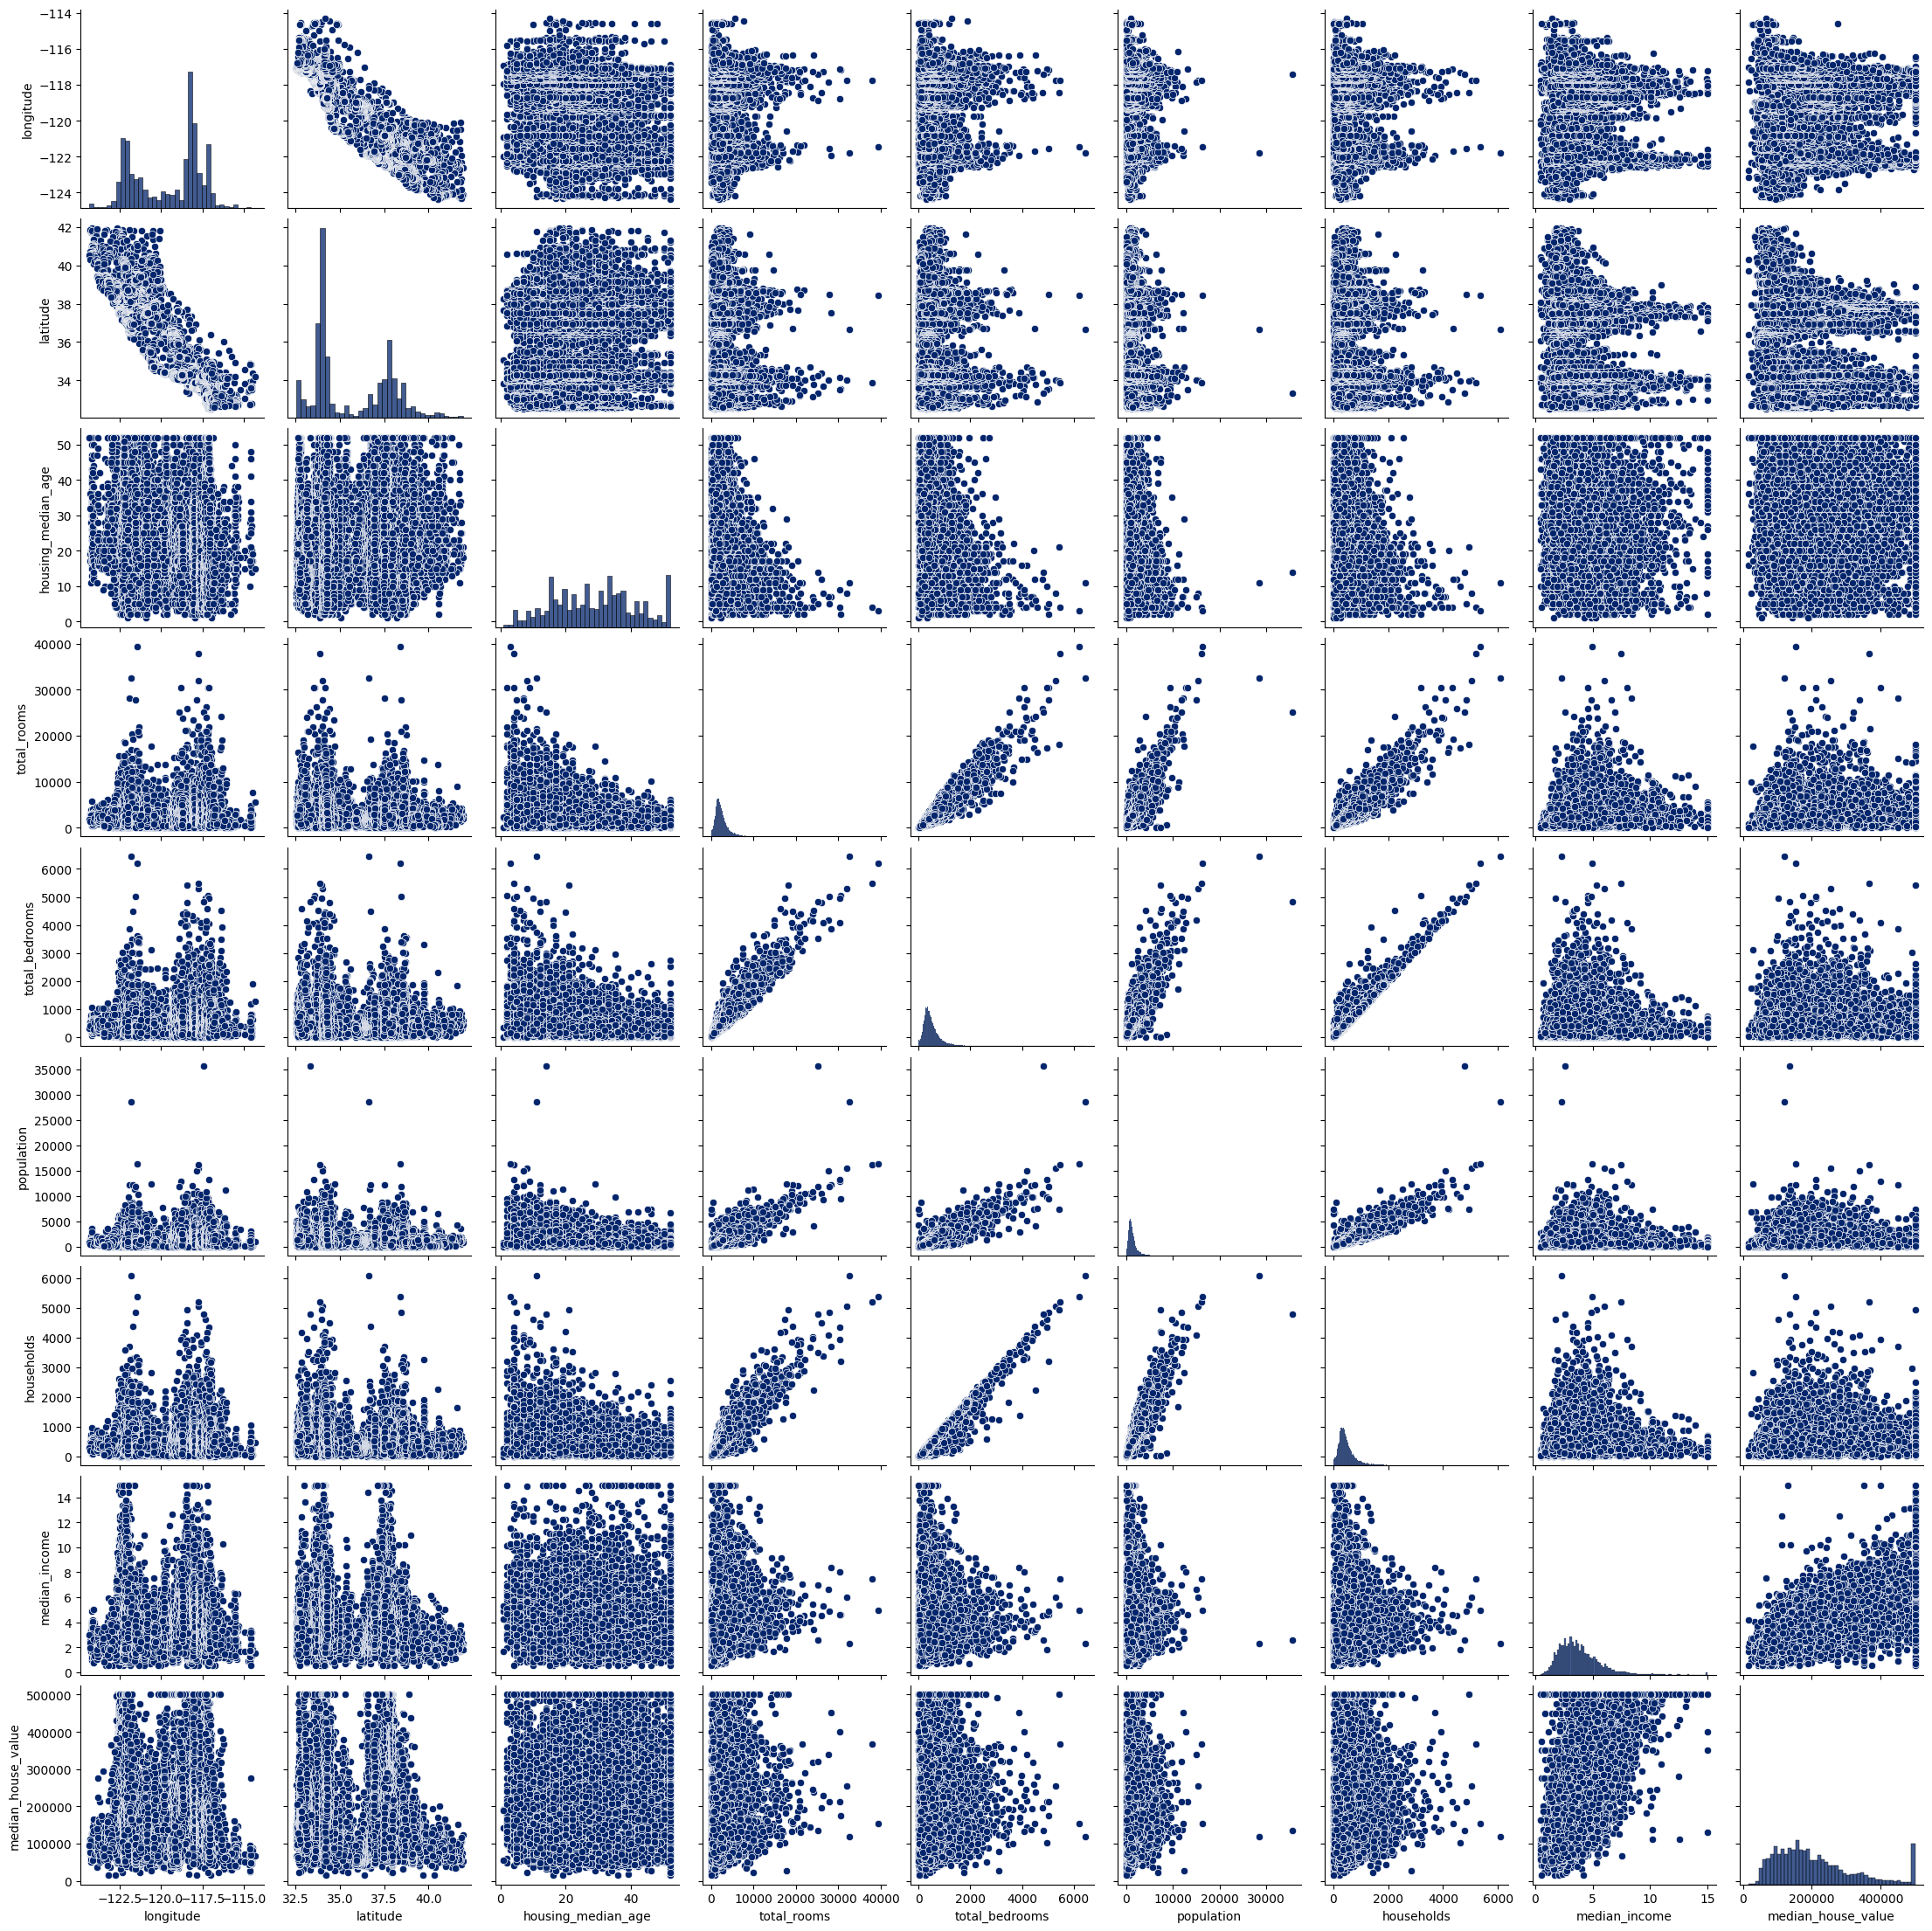

In [20]:
sns.pairplot(df[num_cols])

In [21]:
def plot_heatmap(df_corr, title):
    _, ax = plt.subplots(figsize=(8,6))
    
    ones_corr = np.ones_like(df_corr, dtype=bool)
    
    mask = np.triu(ones_corr)
    adjusted_mask = mask[1:, :-1] 
    adjusted_df_corr = df_corr.iloc[1:, :-1]

    yticks = [i.lower() for i in adjusted_df_corr.index]
    xticks = [i.lower() for i in adjusted_df_corr.columns]

    sns.heatmap(data=adjusted_df_corr, mask=adjusted_mask,
                annot=True, annot_kws={"fontsize":10}, fmt=".2f", 
                vmin=-1, vmax=1,
                linecolor='white', linewidths=0.5)

    ax.set_yticklabels(yticks, rotation=0, fontsize=10)
    ax.set_xticklabels(xticks, rotation=90, fontsize=10)
    plot_title = f'CORRELATION MATRIX\n{title.upper()}\n'
    ax.set_title(plot_title, loc='left', fontsize=14)
    plt.tight_layout()
    plt.show()
    

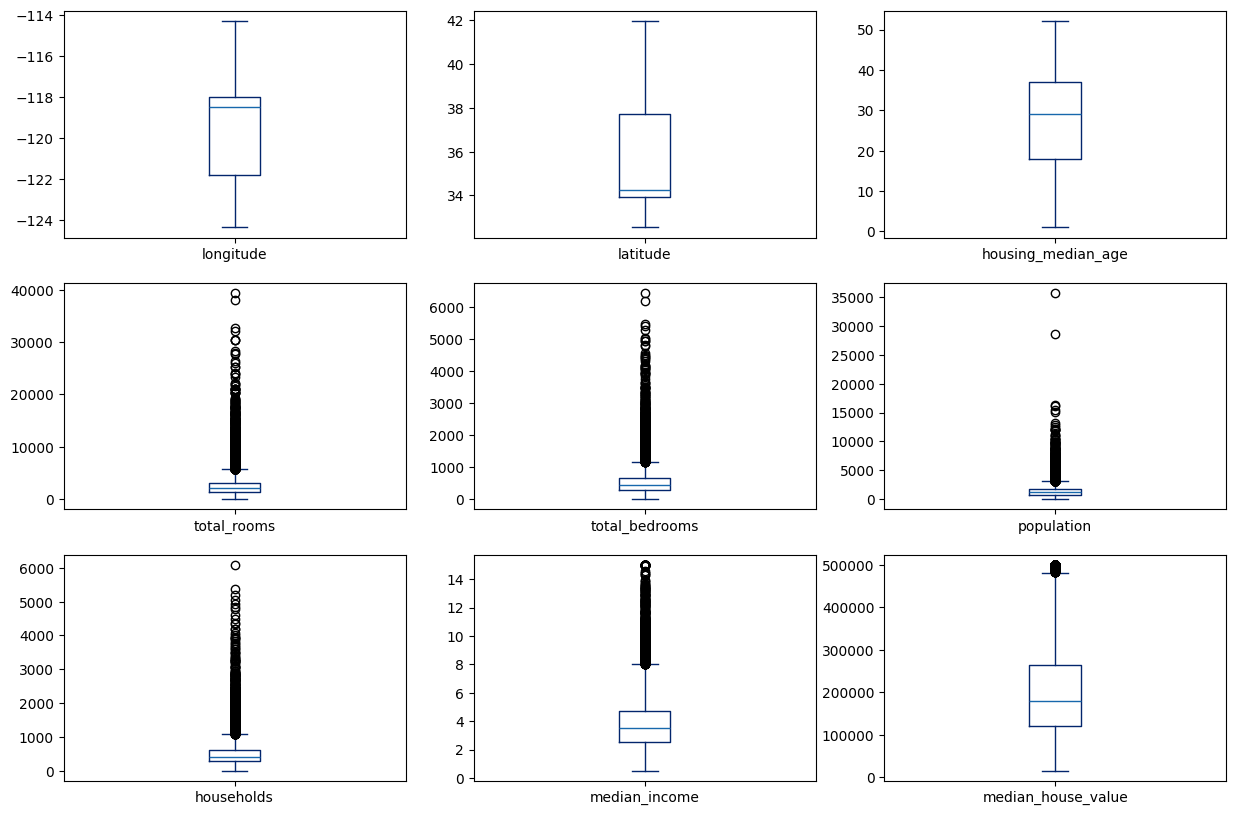

In [22]:
df.plot(kind='box',
        subplots=True,
        layout=(3,3),
        sharex=False,
        sharey=False,
        figsize=(15,10)
)
plt.show()

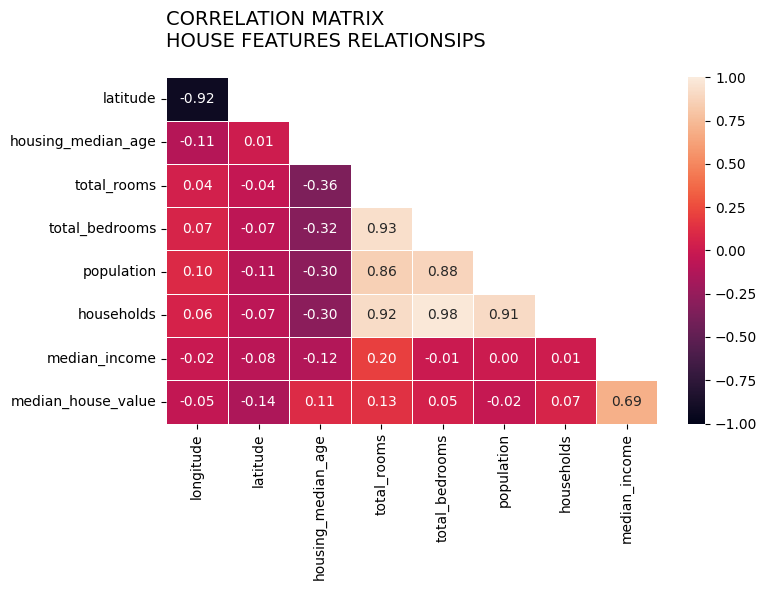

In [23]:
corr_mat = df.corr(numeric_only=True)
plot_heatmap(corr_mat, 'House Features Relationsips')

In [24]:
corr_mat['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [25]:
df['room_p_house'] = df['total_rooms'] / df['households']
df['bedrom_p_house'] = df['total_bedrooms'] / df['total_rooms']
df['people_p_house'] = df['population'] / df['households']
df.corr(numeric_only=True)['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
room_p_house          0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
people_p_house       -0.023737
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bedrom_p_house       -0.255880
Name: median_house_value, dtype: float64

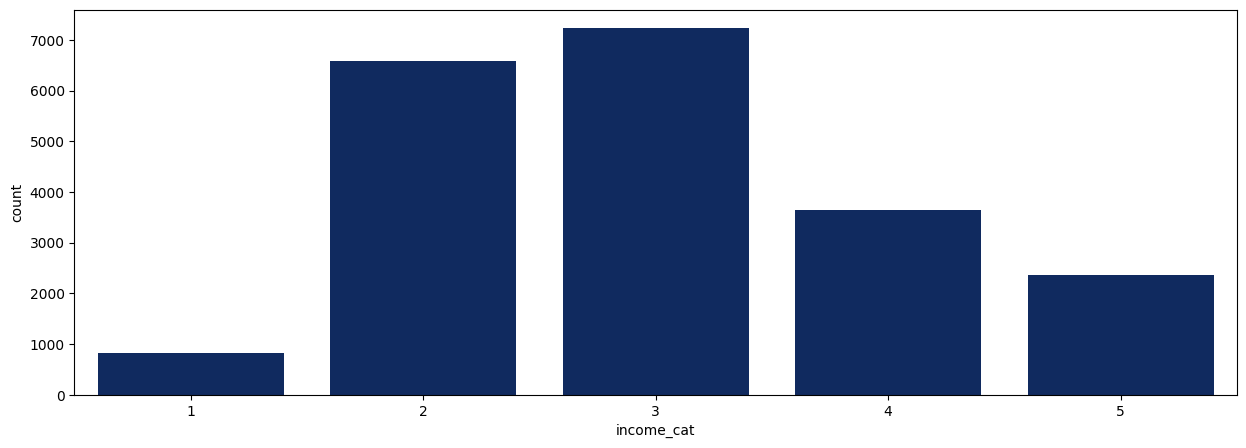

In [26]:
df['income_cat'] = pd.cut(
    df['median_income'],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1,2,3,4,5]
)
plt.figure(figsize=(15,5))
sns.countplot(data=df, x='income_cat')
plt.show()

- Based on the `income_cat` do the stratified sampling

<Axes: xlabel='income_cat', ylabel='Count'>

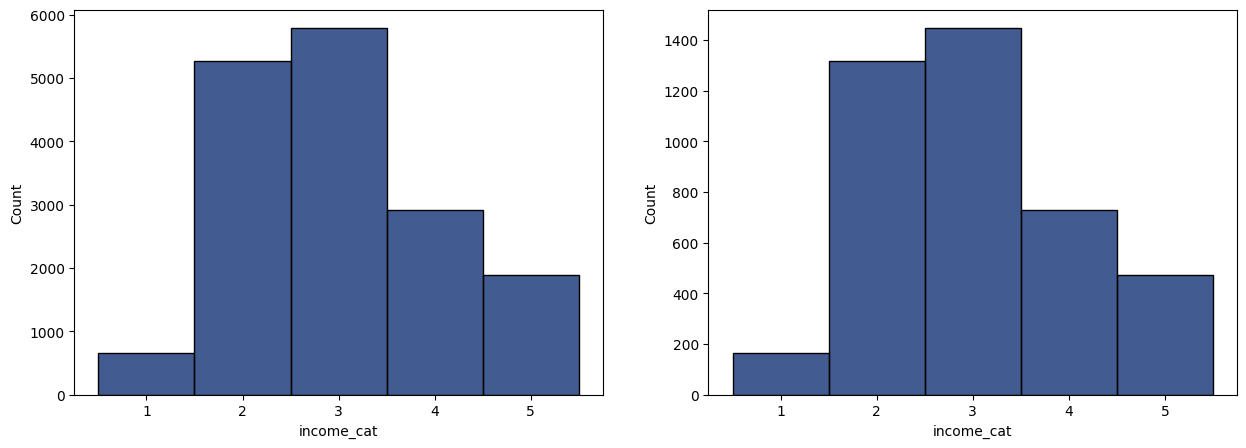

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits = 1,
    test_size=0.2,
    random_state=21
)

for train_i, test_i in split.split(df, df['income_cat']):
    train_set = df.loc[train_i]
    test_set = df.loc[test_i]
    
_, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(train_set['income_cat'], bins=30, ax=axes[0])
sns.histplot(test_set['income_cat'], bins=30, ax=axes[1]) 

In [28]:
exploring_data = train_set.copy()

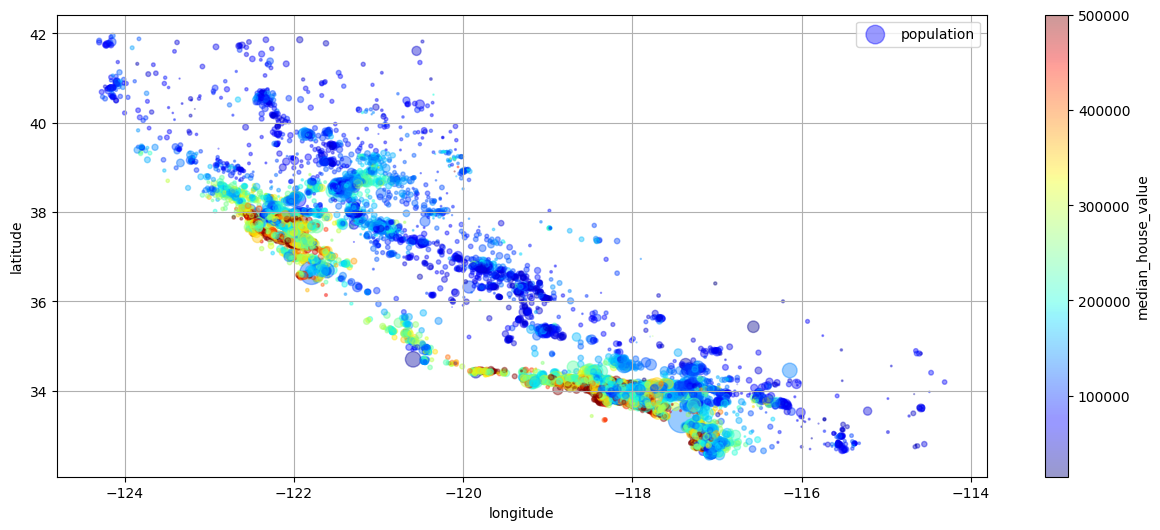

In [29]:
exploring_data.plot(kind="scatter", x="longitude", y="latitude", grid=True,
                     s=exploring_data["population"] / 100, label="population",
                     figsize=(15,6),c='median_house_value',
                     cmap=plt.get_cmap("jet"), colorbar=True,
                     legend=True, sharex=False, alpha=0.4)
plt.legend()
plt.show()

# Prepare data for ML model

In [30]:
train_set.info(), test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13641 to 6043
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           16512 non-null  float64 
 1   latitude            16512 non-null  float64 
 2   housing_median_age  16512 non-null  float64 
 3   total_rooms         16512 non-null  float64 
 4   total_bedrooms      16336 non-null  float64 
 5   population          16512 non-null  float64 
 6   households          16512 non-null  float64 
 7   median_income       16512 non-null  float64 
 8   median_house_value  16512 non-null  float64 
 9   ocean_proximity     16512 non-null  object  
 10  room_p_house        16512 non-null  float64 
 11  bedrom_p_house      16336 non-null  float64 
 12  people_p_house      16512 non-null  float64 
 13  income_cat          16512 non-null  category
dtypes: category(1), float64(12), object(1)
memory usage: 1.8+ MB
<class 'pandas.core.frame.D

(None, None)

In [31]:
from sklearn.metrics.pairwise import rbf_kernel
age_sim_35 = rbf_kernel(train_set[['latitude', 'longitude']], gamma=0.1)


In [32]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin

In [33]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    
    def __init__(self,
                 n_clusters=5, 
                 gamma=1.0, 
                 random_state=42):
        self.n_clusters = n_clusters   
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        
        self.kmeans_ = KMeans(
            n_clusters=self.n_clusters, 
            random_state=self.random_state
        )
        self.kmeans_.fit(X)
        return self
    
    def transform(self, X):
        return rbf_kernel(
            X, 
            self.kmeans_.cluster_centers_,
            gamma=self.gamma
        )
        
    def get_fnames(self, names=None):
        return [f"Cluster_{i} similarity" for i in range(self.n_clusters)]

In [34]:
cluster_simis = ClusterSimilarity(n_clusters=10, gamma=1)
simis = (
    cluster_simis
    .fit(train_set[['latitude', 'longitude']])
    .transform(train_set[['latitude', 'longitude']])
)

In [35]:
simis[0].round(2)

array([0.4 , 0.  , 0.26, 0.  , 0.  , 0.89, 0.  , 0.  , 0.  , 0.  ])

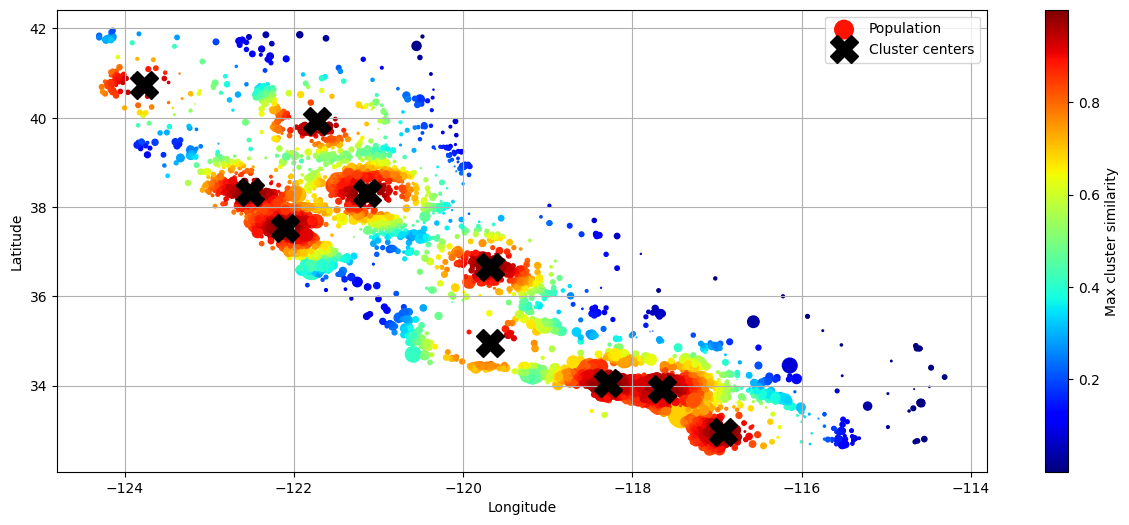

In [36]:
housing_renamed = train_set.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = simis.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(15, 6))
plt.plot(cluster_simis.kmeans_.cluster_centers_[:, 1],
         cluster_simis.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")

plt.show()

## Data Preprocessing

In [37]:
features = np.append(
    num_cols,
    cat_cols
)

get_features = lambda df: df.loc[
    :,
    features[features != target_col]
]
get_target = lambda df: df[target_col]

X_train, y_train = get_features(train_set), get_target(train_set)
X_test, y_test = get_features(test_set), get_target(test_set)

In [38]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13641,-117.33,34.05,26.0,613.0,149.0,431.0,130.0,1.3977,INLAND
12439,-116.18,33.67,25.0,2888.0,654.0,2940.0,660.0,2.2141,INLAND
12218,-117.23,33.57,6.0,13724.0,2269.0,5860.0,1986.0,3.9617,<1H OCEAN
8447,-118.37,33.90,32.0,332.0,103.0,177.0,102.0,3.3409,<1H OCEAN
4843,-118.29,34.03,27.0,1084.0,287.0,1085.0,279.0,2.1350,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
19207,-122.72,38.46,35.0,1445.0,309.0,795.0,308.0,2.9073,<1H OCEAN
1583,-121.97,37.87,4.0,1029.0,126.0,416.0,122.0,13.4883,INLAND
19866,-119.32,36.33,18.0,2603.0,478.0,1158.0,423.0,4.5938,INLAND
17394,-120.44,34.96,39.0,1228.0,379.0,851.0,341.0,1.8990,<1H OCEAN


In [39]:
class DataPrep:
    def __init__(
        self,
        num_features: List[str],
        iqr_bound: float = 1.5,
        log_target: bool = False,
        direction: str = 'both'
    ):
        """_summary_

        Args:
            num_features (List[str]): _description_
            iqr_bound (float, optional): _description_. Defaults to 1.5.
            log_target (bool, optional): _description_. Defaults to False.
        """
        self.num_features = num_features
        self.iqr_bound = iqr_bound
        self.log_target = log_target
        self.dir = direction
        self.lower_bound = None
        self.upper_bound = None
        
    def fit(
        self,
        X: pd.DataFrame,
    ):
        """_summary_

        Args:
            X (pd.DataFrame): _description_
        """
        q1 = X[self.num_features].quantile(0.25)
        q3 = X[self.num_features].quantile(0.75)
        iqr = q3 - q1
        self.lower_bound = q1 - self.iqr_bound * iqr
        self.upper_bound = q3 + self.iqr_bound * iqr

        return self
    def transform(
        self,
        X: pd.DataFrame,
        y: pd.Series,
    ) -> pd.DataFrame:
        X = X.copy()
        X = self._rm_outliers(X)
        if self.log_target:
            y = np.log1p(y)
        return X,y
        
    def _rm_outliers(self, df: pd.DataFrame):
        for col in self.num_features:
            df.loc[
                df[col] < self.lower_bound[col],
                col
            ] = self.lower_bound[col]
            
            df.loc[
                df[col] > self.upper_bound[col],
                col
            ] = self.upper_bound[col]
        return df


In [40]:
X_train_prep, y_train_prep = (
    DataPrep(num_features=num_cols[num_cols != target_col])
    .fit(X_train)
    .transform(X_train, y_train)
)

X_test_prep, y_test_prep = (
    DataPrep(num_features=num_cols[num_cols != target_col])
    .fit(X_train)
    .transform(X_test, y_test)
)


In [41]:
import numpy as np  # Add this import statement

from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

def ratio_pl():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(lambda cols: cols[:, [0]] / cols[:, [1]], feature_names_out='one-to-one'),
        StandardScaler()
    )

def binning_pl(n_bins, encode, strategy):
    return make_pipeline(
        SimpleImputer(strategy='median'),
        KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
    )

log_pl = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler()
)

cat_pl = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)


simi_pl = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)

default_num_pl = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessor = ColumnTransformer([
    ('bedroom_p_room', ratio_pl(), ['total_bedrooms', 'total_rooms']),
    ('rooms_p_house', ratio_pl(), ['total_rooms', 'households']),
    ('pp_p_house', ratio_pl(), ['population', 'households']),
    # ('bin', binning_pl(n_bins=7, encode='onehot', strategy='quantile'), ['housing_median_age']),
    ('log', log_pl, ['median_income', 'total_bedrooms', 'total_rooms', 'population', 'households']),
    ('cat', cat_pl, make_column_selector(dtype_include=object)),
    ('geo', simi_pl, ['latitude', 'longitude'])
], remainder=default_num_pl)


In [42]:
preprocessor.fit(X_train_prep)

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedroom_p_room',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function ratio_pl.<locals>.<lambda> at 0x...
                                 ['median_income', 'total_bedrooms',
                                  'total_rooms', 'population', 'households']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x28abaa120>),
                                ('geo',
                                 ClusterSimilarity(gamma=1, n_clusters=10),
                                 ['latitude', 'longitude'])])

In [155]:

from sklearn.model_selection import cross_val_score, cross_validate
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from tqdm import tqdm

class ModelTrainer:
    def __init__(self, models, preprocessor):
        """
        Initialize the cross-validation trainer.
        :param model: An sklearn estimator object or similar model object.
        :param preprocessor: A defined feature transformation object.
        
        """
        self.models = models
        self.preprocessor = preprocessor
        self.cv_results = None
    
        
    def fit(self, X, y, scoring, nsplits=10, nrepeats=3, random_state=42):
        """
        Train the model(s) using cross-validation.
        
        :param X: The input features (training data).
        :param y: The target labels/values.
        :return: A summary of cross-validation scores.
        """
        self.scoring = scoring
        self.cv_results = [
            
            cross_validate(
                
                Pipeline(steps=[
                    ('preprocessor', self.preprocessor),
                    ('model', model)
                ]),
                
                X, y,
                cv= RepeatedStratifiedKFold(n_splits=nsplits, n_repeats=nrepeats, random_state=random_state),
                scoring=scoring,
            )
            
            for model in tqdm(self.models)
        ]
        return self

    # def evaluate(self):
    #     """
    #     Evaluate model performance across folds using cross-validation.
        
    #     :param X: The input features (evaluation data).
    #     :param y: The target labels/values.
    #     :return: A summary of evaluation scores.
    #     """
    #     if not self.cv_results:
    #         raise ValueError("The models must be trained with `fit` before evaluation.")
        
    #     means = [np.mean(-res) for res in self.cv_results]
    #     stds = [np.std(-res) for res in self.cv_results]

    #     print({
    #         "mean":means, 
    #         "std": stds
    #     })
    #     return self
    
    def evaluate(self):
        """
        Evaluate model performance across folds using cross-validation.

        :return: A DataFrame containing a summary of evaluation scores for each model and metric.
        """
        if not self.cv_results or not self.scoring:
            raise ValueError("The models must be trained with `fit` before evaluation.")

        # Create an empty DataFrame to store all scores
        columns = ["Model"]
        for metric in self.scoring:
            columns.append(f"Mean {metric}")
            columns.append(f"Std {metric}")

        # Prepare a summary DataFrame for each model's scores
        summary_data = []
        for model, results in zip(self.models, self.cv_results):
            row = [model.__class__.__name__]
            for metric in self.scoring:
                scores = results[f'test_{metric}']
                mean_score = -np.mean(scores)
                std_score = np.std(scores)
                row.append(mean_score)
                row.append(std_score)
            summary_data.append(row)

        # Create a DataFrame from the summary data
        self.cv_results = pd.DataFrame(summary_data, columns=columns)
        return self
    def get_results(self):
        return self.cv_results
    

In [156]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor


models = [
    LinearRegression()
    ,Ridge(), Lasso(), 
    ElasticNet(),GradientBoostingRegressor(), 
    RandomForestRegressor(), XGBRegressor()
]

In [157]:
trainer = ModelTrainer(models, preprocessor).fit(X_train_prep, y_train_prep, ['neg_root_mean_squared_error'])

100%|██████████| 7/7 [11:44<00:00, 100.64s/it]


In [158]:
df = trainer.evaluate().get_results()

<Axes: ylabel='Model'>

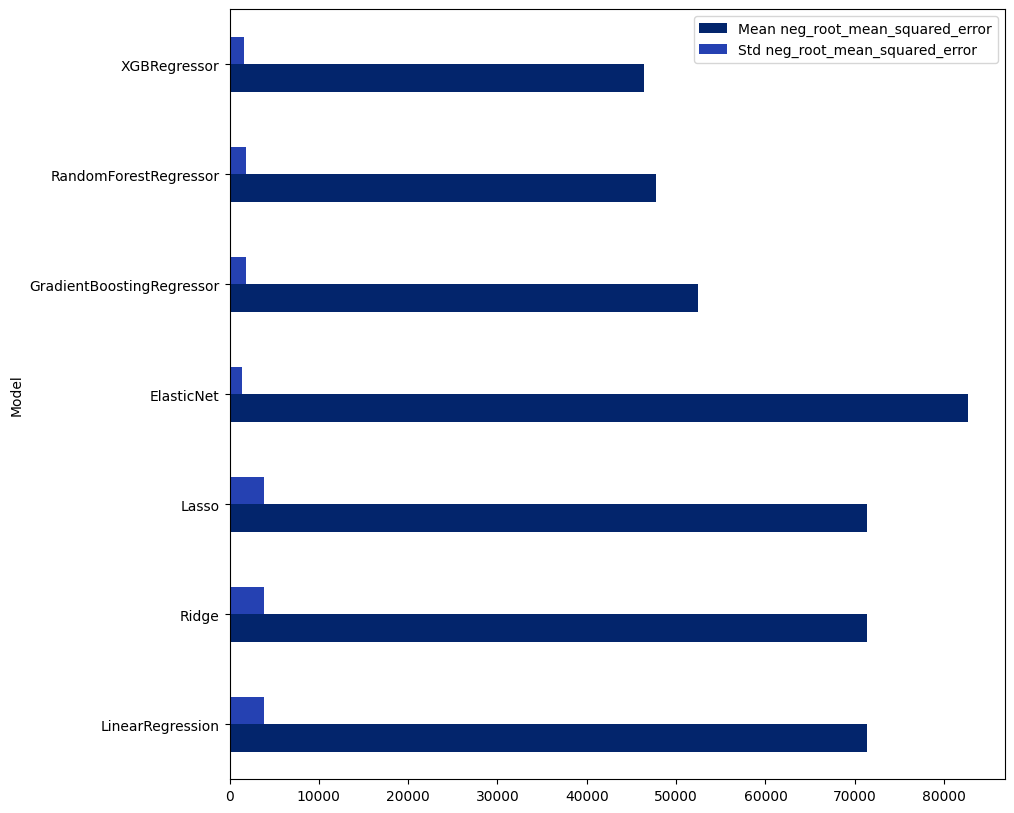

In [159]:
df.set_index('Model').plot(kind='barh', figsize=(10,10))